In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from datetime import datetime, timedelta, date
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from time import time
import joblib

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [23]:
df = pd.read_csv("../runkeeper_data/P1/cardioActivities.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
Activity Id                 20 non-null object
Date                        20 non-null object
Type                        20 non-null object
Route Name                  0 non-null float64
Distance (km)               20 non-null float64
Duration                    20 non-null object
Average Pace                20 non-null object
Average Speed (km/h)        20 non-null float64
Calories Burned             20 non-null float64
Climb (m)                   20 non-null int64
Average Heart Rate (bpm)    19 non-null float64
Friend's Tagged             0 non-null float64
Notes                       0 non-null float64
GPX File                    19 non-null object
dtypes: float64(7), int64(1), object(6)
memory usage: 2.3+ KB


In [24]:
df = df.drop(columns=["Friend's Tagged", "Notes", "GPX File", "Average Heart Rate (bpm)", "Route Name", "Activity Id", "Type"])
df.head()

,Date,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m)
0,2020-07-07 20:30:26,5.37,30:32,5:41,10.54,375.0,36
1,2020-07-06 19:53:06,5.37,30:56,5:46,10.41,376.0,39
2,2020-07-04 08:25:43,0.15,1:50,11:58,5.01,19.0,0
3,2020-07-04 05:51:17,21.21,2:18:09,6:31,9.21,1560.0,31
4,2020-07-03 18:17:50,5.70,34:02,5:58,10.05,405.0,3


In [25]:
def get_duration_in_sec(duration):
    duration_str = str(duration)
    duration_parts = duration.split(":")
    num_parts = len(duration_parts)
    multiplier = 1
    total_secs = 0
    
    while num_parts > 0:
        total_secs += multiplier * int(duration_parts[num_parts - 1])
        multiplier *= 60
        num_parts -= 1
        
    return total_secs


get_duration_in_sec("3:51:45")        
        

13905

In [38]:
def get_duration_in_hh_mm_ss(duration_in_sec:float) -> str:
    duration_in_sec= int(duration_in_sec)
    final_duration = ""
    seconds = duration_in_sec % 60
    minutes = ((duration_in_sec % 3600) - seconds) // 60
    hours = duration_in_sec // 3600
    
    if hours:
        final_duration = str(hours) + ":" + str(minutes) + ":" + str(seconds)
    else:
        final_duration = str(minutes) + ":" + str(seconds)
        
    return final_duration

get_duration_in_hh_mm_ss(13905)

'3:51:45'

In [26]:
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["Date"].apply(lambda x: x.date())
df["year"] = df["Date"].apply(lambda x: x.year)
df["month"] = df["Date"].apply(lambda x: x.month)
df["day"] = df["Date"].apply(lambda x: x.day)
df["hour"] = df["Date"].apply(lambda x: x.hour)
df["minute"] = df["Date"].apply(lambda x: x.minute)
df = df.drop(columns=["Date"])

df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

# 0 is Monday and 6 is Sunday
df["day_of_week"] = df.index.weekday
df["is_weekend"] = df["day_of_week"].apply(lambda x: x==5 or x==6)
df["duration_sec"] = df["Duration"].apply(get_duration_in_sec)
df.head()

,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),year,month,day,hour,minute,day_of_week,is_weekend,duration_sec
date,,,,,,,,,,,,,,
2020-07-07,5.37,30:32,5:41,10.54,375.0,36,2020,7,7,20,30,1,False,1832
2020-07-06,5.37,30:56,5:46,10.41,376.0,39,2020,7,6,19,53,0,False,1856
2020-07-04,0.15,1:50,11:58,5.01,19.0,0,2020,7,4,8,25,5,True,110
2020-07-04,21.21,2:18:09,6:31,9.21,1560.0,31,2020,7,4,5,51,5,True,8289
2020-07-03,5.70,34:02,5:58,10.05,405.0,3,2020,7,3,18,17,4,False,2042


In [27]:
# Get median speed --> done
# Get median duration --> done
# Weekend, Hour of day - Duration, Km (slice and dice)
# Outlier duration (too short runs!)
# For valid runs, which runs have lesser average speed 

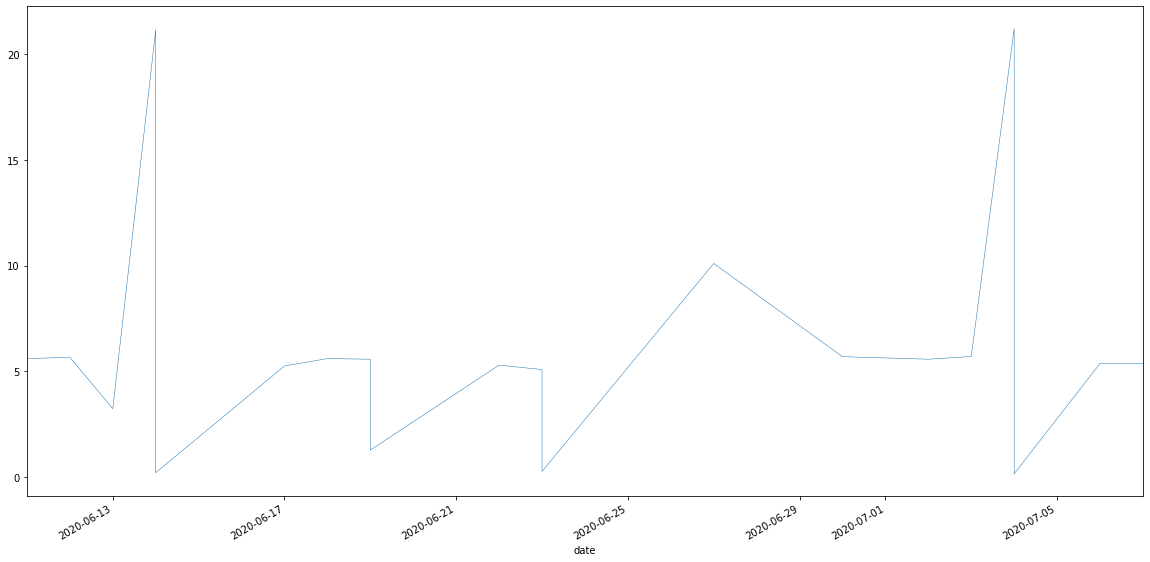

In [30]:
df["Distance (km)"].plot(linewidth=0.5)

In [31]:
df["Average Speed (km/h)"].median()

10.36

In [39]:
get_duration_in_hh_mm_ss(df["duration_sec"].median())

'31:13'

In [40]:
round(df["Distance (km)"].median(),2)

5.47